In [1]:
import matplotlib.pyplot as plt
from hiive.mdptoolbox import example, mdp
import gym
import numpy as np
from frozenlake_env import FrozenLakeEnv
from tqdm import tqdm

In [2]:
#P, R = example.forest(S=100, r1=10, r2=5, p=0.001)
# P, R = example.rand(10000, 4)

In [3]:
def getTransitionAndReward(env):
    nA, nS = env.nA, env.nS
    T = np.zeros([nA, nS, nS])
    R = np.zeros([nS, nA])
    for s in range(nS):
        for a in range(nA):
            transitions = env.P[s][a]
            for p_trans, next_s, reward, _ in transitions:
                T[a,s,next_s] += p_trans
                R[s,a] = reward
            T[a,s,:] /= np.sum(T[a,s,:])
    return T, R

In [4]:
def simulateGymEnv(env, policy, numEpisodes, max_iters=1000):
    rewards = []
    lengths = []
    failed = 0
    for i in range(numEpisodes):
        env.reset()
        state = 0
        done = False
        count = 0
        reward_sum = 0

        while not done:
            action = policy[state]
            state, reward, done, _ = env.step(action)
            reward_sum += reward
            count += 1
            
            if count > max_iters:
                failed += 1
                break
        
        lengths.append(count)
        rewards.append(reward_sum)
    return lengths, rewards

In [5]:
def plotStats(lengths, rewards):
    count = 0
    for i in rewards:
        if i == 1.0:
            count += 1
    print(count / len(rewards))
    
    # Total reward per episode and average reward per step for each episode
    _, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes[0][0].plot(x, rewards)
    axes[0][0].set_xlabel('Episode')
    axes[0][0].set_ylabel('Total Reward')
    axes[0][0].grid()

    avg_reward = [rewards[i] / lengths[i] for i in range(len(rewards))]
    axes[0][1].plot(x, avg_reward)
    axes[0][1].set_xlabel('Episode')
    axes[0][1].set_ylabel('Avg. Reward per Step')
    axes[0][1].grid()
    
    axes[1][0].plot(x, lengths)
    axes[1][0].set_xlabel('Episode')
    axes[1][0].set_ylabel('Steps')
    axes[1][0].grid()
    

In [6]:
# credit https://github.com/wesley-smith/CS7641-assignment-4/blob/f3d86e37504dda563f65b3267610a30f09d01c77/helpers.py
TERM_STATE_MAP = {"4x4": [5, 7, 11, 12], "8x8": [19, 29, 35, 41, 42, 46, 49, 52, 54, 59]}
GOAL_STATE_MAP = {"4x4": [15], "8x8": [63]}
cmap = 'cool'
def visualize_env(env, name, title=None):
    shape = env.desc.shape
    M = shape[0]
    N = shape[1]
    arr = np.zeros(shape)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                arr[i, j] = 0.25
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                arr[i, j] = 1.0
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(arr, cmap=cmap)
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)

    for i in range(M):
        for j in range(N):
            if (i, j) == (0, 0):
                ax.text(j, i, 'S', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in TERM_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k', size=18)
            else:
                ax.text(j, i, 'F', ha='center', va='center', color='k', size=18)
    fig.tight_layout()
    if title:
        ax.set_title(title)
    plt.show()

def visualize_policy(policy, shape, name, title=None):
    M = shape[0]
    N = shape[1]
    actions = np.asarray(policy).reshape(shape)
    mapping = {
        0: '←',
        1: '↓',
        2: '→',
        3: '↑'
    }
    arr = np.zeros(shape)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                arr[i, j] = 0.25
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                arr[i, j] = 1.0
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(arr, cmap=cmap)
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)

    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k', size=18)
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k', size=18)
            else:
                ax.text(j, i, mapping[actions[i, j]], ha='center', va='center', color='k', size=18)
    # fig.tight_layout()
    if title:
        ax.set_title(title)
    plt.show()

def visualize_value(V, shape, name, title=None):
    V = np.asarray(V)
    M = shape[0]
    N = shape[1]
    fig, ax = plt.subplots(figsize=(6,6))
    arr = V.reshape(shape)
    im = ax.imshow(arr, cmap=cmap)
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in TERM_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k')
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k')
            else:
                ax.text(j, i, '%.2f' % (arr[i, j]), ha='center', va='center', color='k')
    # fig.tight_layout()
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('State-value estimate', rotation=-90, va="bottom")
    if title:
        ax.set_title(title)
    plt.show()

In [75]:
name = "8x8"
env = FrozenLakeEnv(map_name=name, penalty=0.0, prob=0.33)
T, R = getTransitionAndReward(env)

In [9]:
print(T)

[[[0.665 0.    0.    ... 0.    0.    0.   ]
  [0.33  0.335 0.    ... 0.    0.    0.   ]
  [0.    0.33  0.335 ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 0.335 0.    0.   ]
  [0.    0.    0.    ... 0.33  0.335 0.   ]
  [0.    0.    0.    ... 0.    0.    1.   ]]

 [[0.335 0.335 0.    ... 0.    0.    0.   ]
  [0.335 0.    0.335 ... 0.    0.    0.   ]
  [0.    0.335 0.    ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 0.33  0.335 0.   ]
  [0.    0.    0.    ... 0.335 0.33  0.335]
  [0.    0.    0.    ... 0.    0.    1.   ]]

 [[0.335 0.33  0.    ... 0.    0.    0.   ]
  [0.    0.335 0.33  ... 0.    0.    0.   ]
  [0.    0.    0.335 ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 0.335 0.33  0.   ]
  [0.    0.    0.    ... 0.    0.335 0.33 ]
  [0.    0.    0.    ... 0.    0.    1.   ]]

 [[0.665 0.335 0.    ... 0.    0.    0.   ]
  [0.335 0.33  0.335 ... 0.    0.    0.   ]
  [0.    0.335 0.33  ... 0.    0.    0.   ]
  ...
  [0.    0.    0.    ... 0.    0.335 0.   ]
  

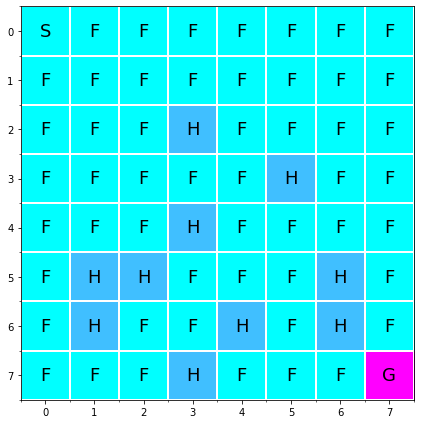

In [18]:
visualize_env(env, name)

In [97]:
#try varying gammas from 0 to 1
#at 0 the agent only considers immediate rewards
#at 1 the agent considers all futures rewards equally
gammas = np.arange(0.95, 0.99, 0.01)
print(gammas)

[0.95 0.96 0.97 0.98 0.99]


## Value Iteration

0.95 0.368 0.0005263157894736847
0.96 0.416 0.000416666666666667
0.97 0.406 0.0003092783505154642
0.98 0.41 0.0002040816326530614
0.99 0.462 0.00010101010101010109


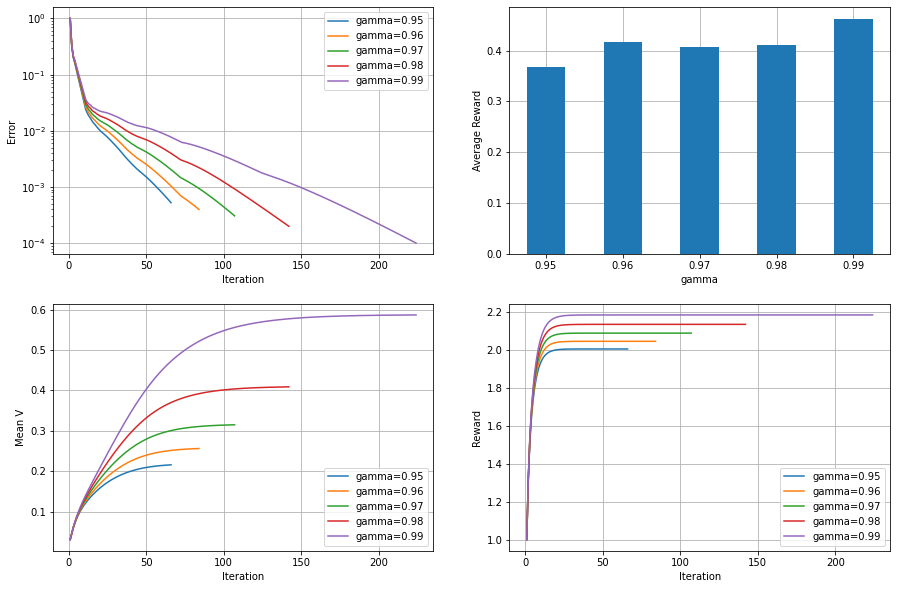

In [99]:
_, ax = plt.subplots(2, 2, figsize=(15, 10))
avg_rewards = []
for gamma in gammas:
    vi = mdp.ValueIteration(T, R, gamma)
    vi.verbose = False
    vi.run()
    episodes = 500
    x = range(episodes)
    vi_lengths, vi_rewards = simulateGymEnv(env, vi.policy, episodes)
    print(gamma, sum(vi_rewards) / episodes, vi.thresh)
    avg_rewards.append(sum(vi_rewards) / episodes)
   
    # Policy change per iteration
    ax[0][0].semilogy(range(1, vi.iter + 1), [run['Error'] for run in vi.run_stats], label="gamma=%.2f" % gamma)
    ax[0][0].set_xlabel('Iteration')
    ax[0][0].set_ylabel('Error')
    ax[0][0].grid()
    ax[0][0].legend()
    
    ax[1][0].plot(range(1, vi.iter + 1), [run['Mean V'] for run in vi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][0].set_xlabel('Iteration')
    ax[1][0].set_ylabel('Mean V')
    ax[1][0].grid()
    ax[1][0].legend()
    
    ax[1][1].plot(range(1, vi.iter + 1), [run['Reward'] for run in vi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][1].set_xlabel('Iteration')
    ax[1][1].set_ylabel('Reward')
    ax[1][1].grid()
    ax[1][1].legend()

# Time
ax[0][1].bar(gammas, avg_rewards, width=0.005)
ax[0][1].set_xlabel('gamma')
ax[0][1].set_ylabel('Average Reward')
ax[0][1].set_axisbelow(True)
ax[0][1].grid()

plt.show()


224 0.01260995864868164
(3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 2, 0, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0)


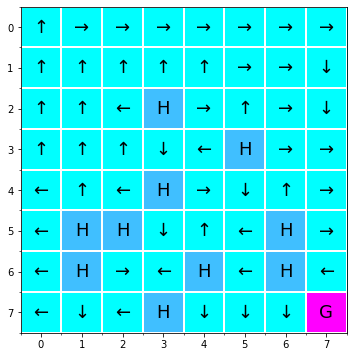

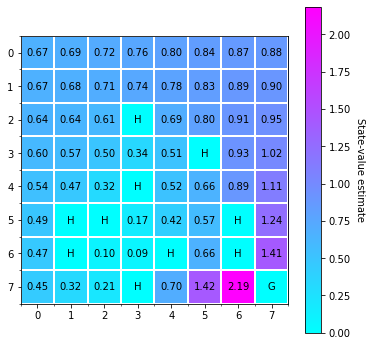

In [64]:
vi = mdp.ValueIteration(T, R, 0.99, epsilon=0.01)
vi.run()
print(vi.iter, vi.time)
print(vi.policy)
visualize_policy(vi.policy, (8,8), name)
visualize_value(vi.V, (8,8), name)

In [65]:
episodes = 100
x = range(episodes)

vi_lengths, vi_rewards = simulateGymEnv(env, vi.policy, episodes)

0.42


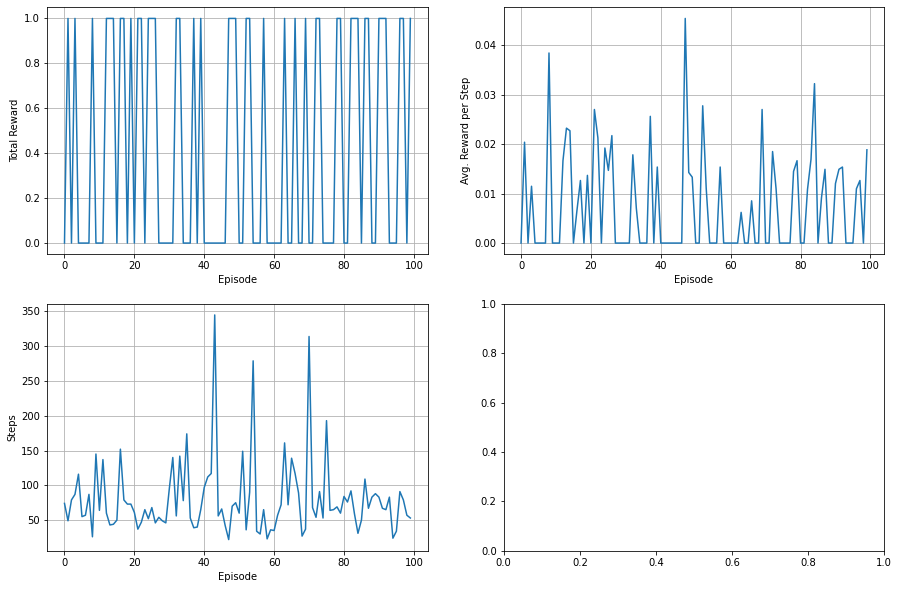

In [66]:
plotStats(vi_lengths, vi_rewards)

## Policy Iteration

0.95 0.406
0.96 0.398
0.97 0.384
0.98 0.424
0.99 0.452


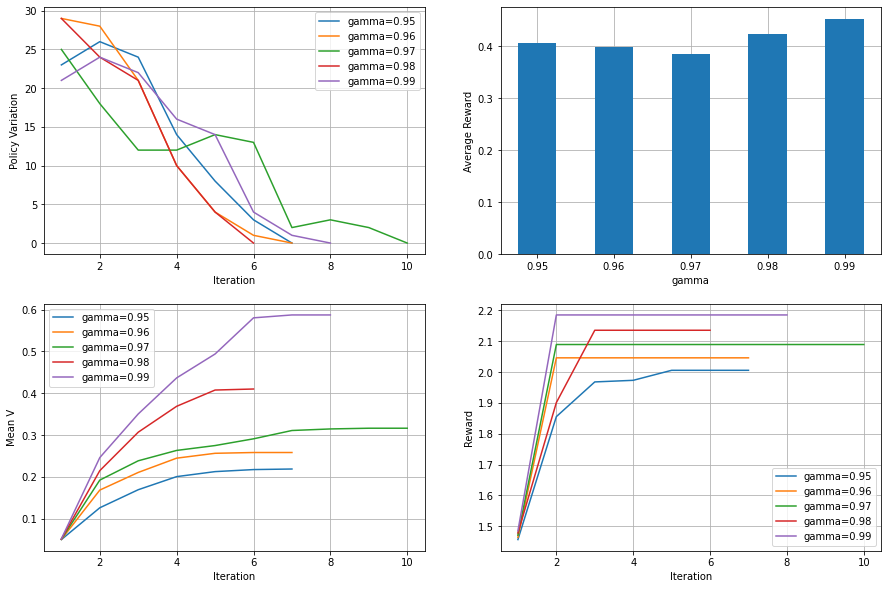

In [101]:
_, ax = plt.subplots(2, 2, figsize=(15, 10))
avg_rewards = []
for gamma in gammas:
    pi = mdp.PolicyIteration(T, R, gamma)
    pi.run()
    episodes = 500
    x = range(episodes)
    pi_lengths, pi_rewards = simulateGymEnv(env, pi.policy, episodes)
    print(gamma, sum(pi_rewards) / episodes)
    avg_rewards.append(sum(pi_rewards) / episodes)
    
    # Policy change per iteration
    ax[0][0].plot(range(1, pi.iter + 1), pi.variation, label="gamma=%.2f" % gamma)
    ax[0][0].set_xlabel('Iteration')
    ax[0][0].set_ylabel('Policy Variation')
    ax[0][0].grid()
    ax[0][0].legend()
    
    ax[1][0].plot(range(1, pi.iter + 1), [run['Mean V'] for run in pi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][0].set_xlabel('Iteration')
    ax[1][0].set_ylabel('Mean V')
    ax[1][0].grid()
    ax[1][0].legend()
    
    ax[1][1].plot(range(1, pi.iter + 1), [run['Reward'] for run in pi.run_stats], label="gamma=%.2f" % gamma)
    ax[1][1].set_xlabel('Iteration')
    ax[1][1].set_ylabel('Reward')
    ax[1][1].grid()
    ax[1][1].legend()
    
# Time
ax[0][1].bar(gammas, avg_rewards, width=0.005)
ax[0][1].set_xlabel('gamma')
ax[0][1].set_ylabel('Average Reward')
ax[0][1].set_axisbelow(True)
ax[0][1].grid()

plt.show()

8 0.013235330581665039


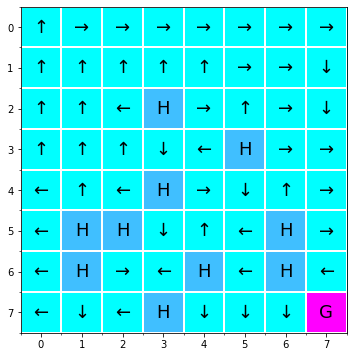

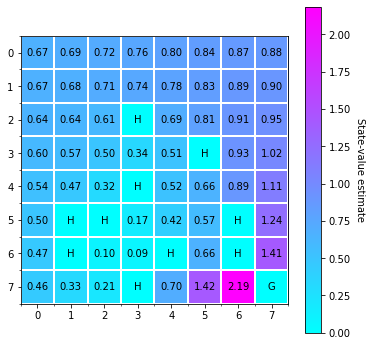

In [49]:
pi = mdp.PolicyIteration(T, R, 0.99)
pi.run()
print(pi.iter, pi.time)
visualize_policy(pi.policy, (8,8), name)
visualize_value(pi.V, (8,8), name)

In [44]:
episodes = 100
x = range(episodes)

pi_lengths, pi_rewards = simulateGymEnv(env, pi.policy, episodes)

In [45]:
print(pi.policy)

(3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 2, 0, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0)


0.43


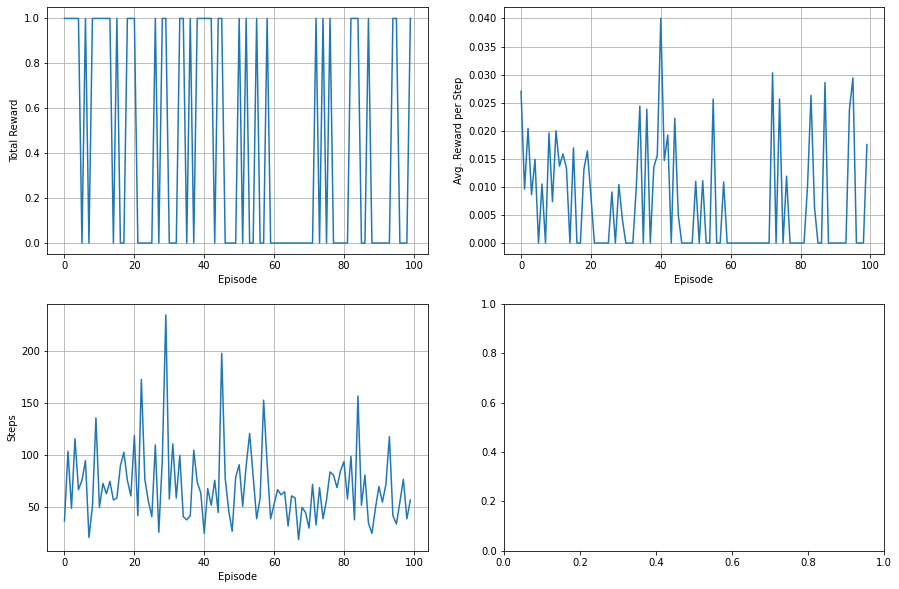

In [46]:
plotStats(pi_lengths, pi_rewards)

In [104]:
epsilons = np.geomspace(0.01, 0.99, 5)
print(epsilons)
alphas = [0.1, 0.01, 0.001]
print(alphas)
decays = np.geomspace(0.99, 0.9999999, 10)
print(decays)

params = []
for alpha in alphas:
    params.append((0.99, alpha, 0.999999, 0.95))
print(len(params))

[0.01       0.03154342 0.09949874 0.31385308 0.99      ]
[0.1, 0.01, 0.001]
[0.99       0.99110614 0.99221352 0.99332214 0.99443199 0.99554309
 0.99665543 0.99776901 0.99888383 0.9999999 ]
3


In [105]:
def runQLearning(params):
    gamma, alpha, decay, epsilon = params
    q = mdp.QLearning(T, R, gamma, n_iter=100000000, 
                      epsilon=epsilon, epsilon_decay=decay,
                      alpha=alpha, alpha_decay=1.0,
                      run_stat_frequency=1000000)
    q.run()
    return (q, {'gamma': gamma, 'alpha': alpha, 'epsilon': epsilon, 'decay': decay})

In [106]:
from multiprocessing import Pool

try:
    pool = Pool()
    q_policies = pool.map(runQLearning, params)
finally:
    pool.close()
    pool.join()

In [107]:
q_policies = [i for i in q_policies]

In [66]:
max_reward = 0
best_policy = []
episodes = 100
x = range(episodes)
for policy in tqdm(q_policies):
    q_lengths, q_rewards = simulateGymEnv(env, policy[0], episodes, max_iters=1000)
    reward = sum(q_rewards)
    if reward > max_reward:
        max_reward = reward
        best_policy = [policy]
    elif reward == max_reward:
        best_policy.append(policy)

100%|██████████| 2500/2500 [00:26<00:00, 95.69it/s] 


In [67]:
print(max_reward, best_policy)

35.0 [((0, 0, 2, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 1, 1, 0), {'gamma': 0.96, 'alpha': 0.19849253305842324, 'epsilon': 0.01, 'decay': 0.9999999})]


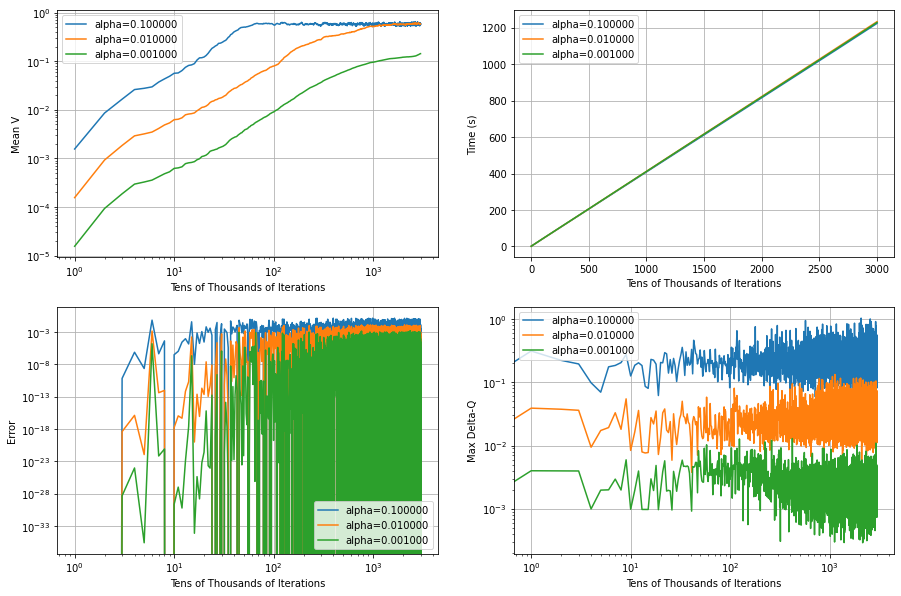

In [29]:
_, ax = plt.subplots(2, 2, figsize=(15, 10))
for q in q_policies:
    alpha = q[1]['alpha']
    q = q[0]
    stat_iters = len(q.run_stats)
    q_mean_v = [stats['Mean V'] for stats in q.run_stats]
    q_error = [stats['Error'] for stats in q.run_stats]
    q_time = [stats['Time'] for stats in q.run_stats]

    # mean v per iteration
    ax[0][0].loglog(range(1, stat_iters + 1), q_mean_v, label="alpha=%f" % alpha)
    ax[0][0].set_xlabel('Tens of Thousands of Iterations')
    ax[0][0].set_ylabel('Mean V')
    ax[0][0].grid()
    ax[0][0].legend()
    # Time
    ax[0][1].plot(range(1, stat_iters + 1), q_time, label="alpha=%f" % alpha)
    ax[0][1].set_xlabel('Tens of Thousands of Iterations')
    ax[0][1].set_ylabel('Time (s)')
    ax[0][1].grid()
    ax[0][1].legend()

    ax[1][0].loglog(range(1, stat_iters + 1), q_error, label="alpha=%f" % alpha)
    ax[1][0].set_xlabel('Tens of Thousands of Iterations')
    ax[1][0].set_ylabel('Error')
    ax[1][0].grid()
    ax[1][0].legend()

    ax[1][1].loglog(range(len(q.variation)), q.variation, label="alpha=%f" % alpha)
    ax[1][1].set_xlabel('Tens of Thousands of Iterations')
    ax[1][1].set_ylabel('Max Delta-Q')
    ax[1][1].grid()
    ax[1][1].legend()

plt.show()

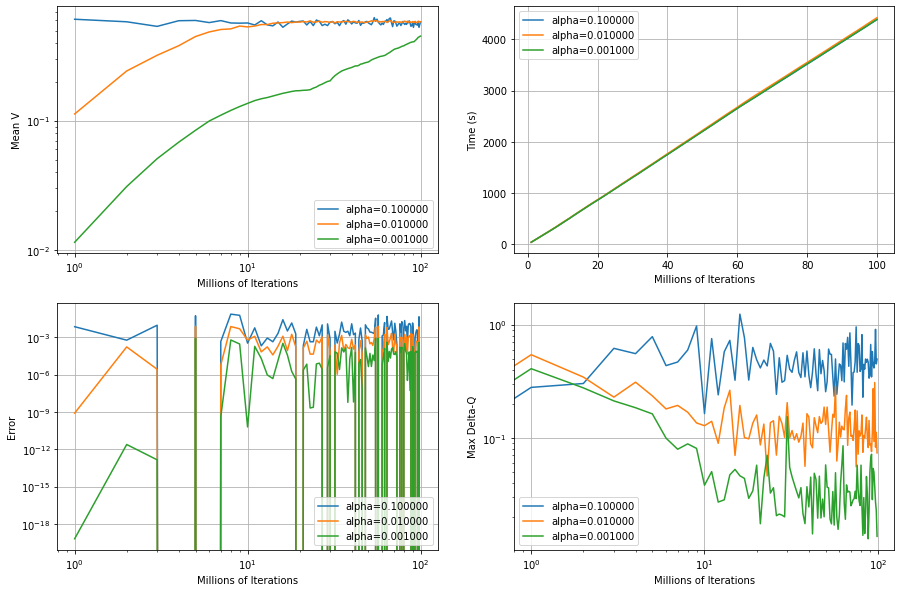

In [109]:
_, ax = plt.subplots(2, 2, figsize=(15, 10))
for q in q_policies:
    alpha = q[1]['alpha']
    q = q[0]
    stat_iters = len(q.run_stats)
    q_mean_v = [stats['Mean V'] for stats in q.run_stats]
    q_error = [stats['Error'] for stats in q.run_stats]
    q_time = [stats['Time'] for stats in q.run_stats]

    # mean v per iteration
    ax[0][0].loglog(range(1, stat_iters + 1), q_mean_v, label="alpha=%f" % alpha)
    ax[0][0].set_xlabel('Millions of Iterations')
    ax[0][0].set_ylabel('Mean V')
    ax[0][0].grid()
    ax[0][0].legend()
    # Time
    ax[0][1].plot(range(1, stat_iters + 1), q_time, label="alpha=%f" % alpha)
    ax[0][1].set_xlabel('Millions of Iterations')
    ax[0][1].set_ylabel('Time (s)')
    ax[0][1].grid()
    ax[0][1].legend()

    ax[1][0].loglog(range(1, stat_iters + 1), q_error, label="alpha=%f" % alpha)
    ax[1][0].set_xlabel('Millions of Iterations')
    ax[1][0].set_ylabel('Error')
    ax[1][0].grid()
    ax[1][0].legend()

    ax[1][1].loglog(range(len(q.variation)), q.variation, label="alpha=%f" % alpha)
    ax[1][1].set_xlabel('Millions of Iterations')
    ax[1][1].set_ylabel('Max Delta-Q')
    ax[1][1].grid()
    ax[1][1].legend()

plt.show()

In [21]:
q_optimal = mdp.QLearning(T, R, 0.99, n_iter=20000000,
                          epsilon=0.95,
                          epsilon_decay=0.999999,
                          alpha=0.1,
                          alpha_decay=1.0,
                          run_stat_frequency=1000000)
q_optimal.run()

[{'State': 57,
  'Action': 1,
  'Reward': 0.0,
  'Error': 0.013326417705087197,
  'Time': 42.050053358078,
  'Alpha': 0.1,
  'Epsilon': 0.34948564384565023,
  'Gamma': 0.99,
  'Max V': 3.0247676323145956,
  'Mean V': 0.625664985781092,
  'Iteration': 1000000},
 {'State': 10,
  'Action': 3,
  'Reward': 0.0,
  'Error': 0.0029889224200671752,
  'Time': 83.48469614982605,
  'Alpha': 0.1,
  'Epsilon': 0.12856851906736305,
  'Gamma': 0.99,
  'Max V': 2.141495237610468,
  'Mean V': 0.5893902108306246,
  'Iteration': 2000000},
 {'State': 18,
  'Action': 2,
  'Reward': 0.0,
  'Error': 0.0338360984560358,
  'Time': 124.53616261482239,
  'Alpha': 0.1,
  'Epsilon': 0.1,
  'Gamma': 0.99,
  'Max V': 2.1776633130351866,
  'Mean V': 0.5583024084395984,
  'Iteration': 3000000},
 {'State': 21,
  'Action': 3,
  'Reward': 0.0,
  'Error': 0.000561234969111124,
  'Time': 165.63664364814758,
  'Alpha': 0.1,
  'Epsilon': 0.1,
  'Gamma': 0.99,
  'Max V': 2.2567979153264472,
  'Mean V': 0.6002567273033015,
  'I

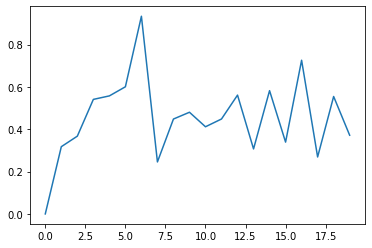

822.6436278820038


In [30]:
plt.figure()
plt.plot(range(len(q_optimal.variation)), q_optimal.variation)
plt.show()
print(q_optimal.time)

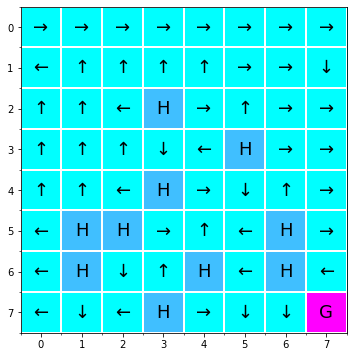

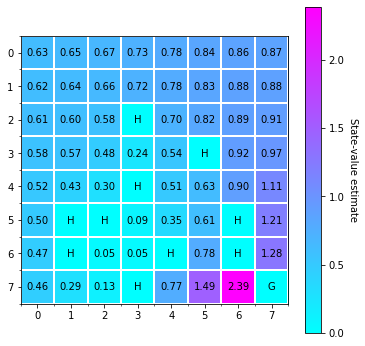

In [23]:
episodes = 100
x = range(episodes)

q_lengths, q_rewards = simulateGymEnv(env, q_optimal.policy, episodes, max_iters=1000)
visualize_policy(q_optimal.policy, (8,8), name)
visualize_value(q_optimal.V, (8,8), name)

0.49


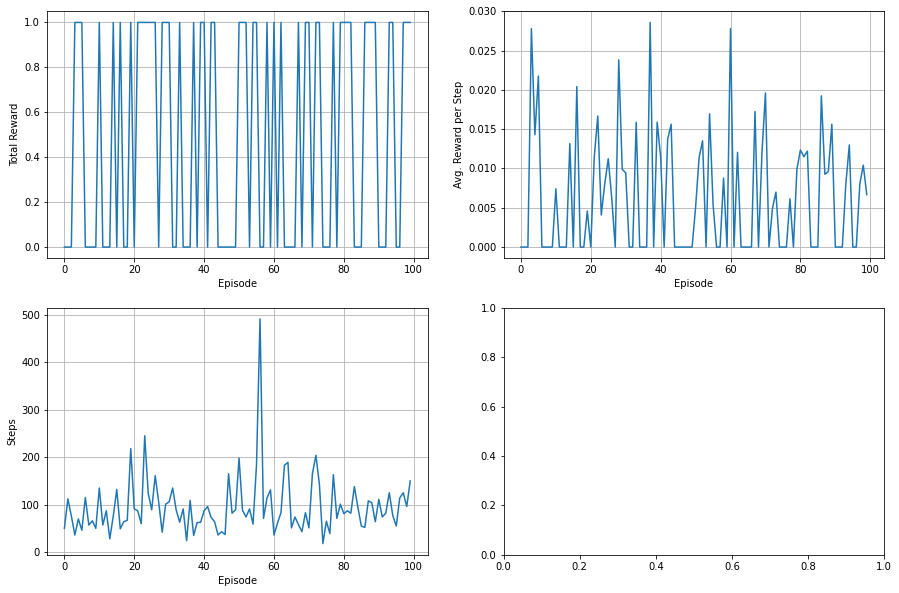

In [24]:
plotStats(q_lengths, q_rewards)

In [103]:
from toh_gym.envs import TohEnv
env = TohEnv(poles=3, rings=6, noise=0.1)
print(env.all_states)

[((6, 5, 4, 3, 2, 1), (), ()), ((6, 5, 4, 3, 2), (1,), ()), ((6, 5, 4, 3, 2), (), (1,)), ((6, 5, 4, 3), (1,), (2,)), ((6, 5, 4, 3), (2,), (1,)), ((6, 5, 4, 3, 1), (), (2,)), ((6, 5, 4, 3), (), (2, 1)), ((6, 5, 4, 3, 1), (2,), ()), ((6, 5, 4, 3), (2, 1), ()), ((6, 5, 4), (3,), (2, 1)), ((6, 5, 4), (2, 1), (3,)), ((6, 5, 4, 1), (3,), (2,)), ((6, 5, 4), (3, 1), (2,)), ((6, 5, 4, 1), (2,), (3,)), ((6, 5, 4), (2,), (3, 1)), ((6, 5, 4, 1), (3, 2), ()), ((6, 5, 4, 2), (3, 1), ()), ((6, 5, 4, 1), (), (3, 2)), ((6, 5, 4, 2), (), (3, 1)), ((6, 5, 4), (3, 2, 1), ()), ((6, 5, 4), (3, 2), (1,)), ((6, 5, 4, 2, 1), (3,), ()), ((6, 5, 4, 2), (3,), (1,)), ((6, 5, 4), (1,), (3, 2)), ((6, 5, 4), (), (3, 2, 1)), ((6, 5, 4, 2, 1), (), (3,)), ((6, 5, 4, 2), (1,), (3,)), ((6, 5), (3, 2, 1), (4,)), ((6, 5), (4,), (3, 2, 1)), ((6, 5, 1), (3, 2), (4,)), ((6, 5), (3, 2), (4, 1)), ((6, 5, 1), (4,), (3, 2)), ((6, 5), (4, 1), (3, 2)), ((6, 5, 1), (3,), (4, 2)), ((6, 5, 2), (3,), (4, 1)), ((6, 5, 1), (4, 2), (3,)), 